In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision import datasets, models
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
#from torchvision.models.segmentation.deeplabv3 import DeepLabHead

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [12]:
import os
import datetime
import random
from PIL import Image
import time

In [4]:
from torchvision.utils import make_grid

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim

In [6]:
#import segmentation_models_pytorch as smp

In [7]:
from datasets import load_dataset

In [8]:
ds = load_dataset("sayakpaul/nyu_depth_v2", cache_dir = "./data")

Found cached dataset nyu_depth_v2 (D:/DLStudy/DepthSegmentation/data/sayakpaul___nyu_depth_v2/default/1.0.0/80157dc55fc37d154eb8157db00139028820c686cd2955a43a1d3850e315c383)


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 100
NUM_WORKERS = 2
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
PIN_MEMORY = True
LOAD_MODEL = True


In [10]:
#model = model = smp.Unet('resnet152', encoder_weights='imagenet')
#model = UNET()

In [11]:
class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.convA( torch.cat([up_x, concat_with], dim=1)  ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=2048, decoder_width = 1.0):
        super(Decoder, self).__init__()
        self.conv2 = nn.Conv2d(num_features, 1024, kernel_size=1, stride=1, padding=0)

        #self.up1 = UpSample(skip_input=features//1 + 256, output_features=features//2)
        

        

    def forward(self, features):
        x_d0 = self.conv2(F.relu(features))

        #x_d1 = self.up1(x_d0, x_block3)

        return x_d0

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()       
        self.original_model = models.resnet50( weights=True )
        self.new_model = torch.nn.Sequential(*(list(self.original_model.children())[:-7]), nn.LeakyReLU(0.2))
    def forward(self, x):
     
        
        
        return self.new_model(x)

class PTModel(nn.Module):
    def __init__(self):
        super(PTModel, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder( self.encoder(x) )
      #  return self.encoder(x)

In [16]:
class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()       
        self.original_model = models.densenet169( weights=True )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features

In [25]:
model = Encoder()
#model = PTModel()

In [26]:
val = torch.rand(1, 3,224,224)

start = time.time()
r= model(val)
end = time.time()
print(end - start)

0.020676374435424805


In [38]:
r.shape

torch.Size([1, 64, 112, 112])

In [27]:
class NYUData(Dataset):
        def __init__(self, chunk):
            #ds = torch.tensor(load_dataset("sayakpaul/nyu_depth_v2", cache_dir = "./data"))
            self.chunk = chunk
            self.data = ds
            
        def __getitem__(self, index):
            flip = random.randint(0,1)
            rot = random.randint(-45,45)
            
            self.rgb_trans = A.Compose([
                A.Resize(width = 224, height = 224),
                A.Normalize(
                       mean = [0.0, 0.0, 0.0],
                        std = [1.0, 1.0, 1.0],
                        max_pixel_value=255
                    ),
                A.HorizontalFlip(p=flip),
               
                A.RandomBrightnessContrast(p = 1),
                
                ToTensorV2()
            ])
            self.dep_trans = A.Compose([
                A.Resize(width = 112, height = 112),
                A.HorizontalFlip(p=flip),
                
                ToTensorV2()
            ])
            image = self.data[self.chunk][index]['image']
            image = TF.rotate(img = image, interpolation = transforms.InterpolationMode.BILINEAR , angle = rot, expand= False)
            image = TF.center_crop(img = image, output_size = [224])
            image = np.array(image)
            image = self.rgb_trans(image = image)["image"]
            
            depth = self.data[self.chunk][index]['depth_map']
            depth = TF.rotate(img = depth, interpolation = transforms.InterpolationMode.BILINEAR, angle = rot, expand= False)
            depth = TF.center_crop(img = depth, output_size = [224])
            depth = np.array(depth)
            
            depth = self.dep_trans(image = depth)["image"]
            return  image , depth 
        def __len__(self):
            return len(self.data[self.chunk])

In [34]:

dataset = NYUData('train')
train_loader = DataLoader(dataset=dataset, batch_size=8)


In [29]:
dataset = NYUData('validation')
data_loader = DataLoader(dataset=dataset, batch_size=64)

In [30]:
model.to(DEVICE)
print("i have no idea what I am doing")

i have no idea what I am doing


In [31]:
def delta_accuracy(predicted_depth, true_depth, threshold=1.25 ):
    assert predicted_depth.shape == true_depth.shape
    max_ratio = torch.max(predicted_depth/true_depth, true_depth/predicted_depth)
    delta_accuracy = torch.mean((max_ratio<threshold).float()) * 100
    return delta_accuracy.item()
    

In [32]:
def average_relative_error(y_true, y_pred):
    y_true = torch.as_tensor(y_true, dtype=torch.float32)
    y_pred = torch.as_tensor(y_pred, dtype=torch.float32)
    

    absolute_differences = torch.abs(y_true - y_pred)
    
    # Avoid division by zero by adding a small constant; adjust as necessary
    epsilon = 1e-8
    relative_errors = absolute_differences / (y_true + epsilon)
    
    # Calculate the mean of relative errors
    average_error = torch.mean(relative_errors)
    
    return average_error

def rmse(y_true, y_pred):
    mse = F.mse_loss(y_pred, y_true, reduction='mean')
    rmse = torch.sqrt(mse)
    return rmse
def average_log10_error(y_true, y_pred):
   
    # Ensure that y_true and y_pred are torch tensors
    y_true = torch.as_tensor(y_true, dtype=torch.float32)
    y_pred = torch.as_tensor(y_pred, dtype=torch.float32)
    
    # Compute the log10 of the absolute ratio of predicted to actual values
    # Adding a small constant to the denominator to prevent division by zero
    epsilon = 1e-8
    log10_errors = torch.log10(torch.abs(y_pred / (y_true + epsilon)))
    
    # Calculate the mean of the absolute log10 errors
    average_log10_error = torch.mean(torch.abs(log10_errors))
    
    return average_log10_error

In [18]:
loop = tqdm(data_loader)

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

In [35]:
len(dataset)

47584

In [20]:
for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device = DEVICE)
    targets = targets.to(device = DEVICE)

    #forward
    with torch.cuda.amp.autocast():
        predictions = model(data)
        print(predictions.shape)
        print(delta_accuracy(predictions, targets, threshold=1.25 ))
        print(delta_accuracy(predictions, targets, threshold=1.5625 ))
        print(delta_accuracy(predictions, targets, threshold=1.95 ))
        print(average_relative_error(targets, predictions))
        print(rmse(targets, predictions))
        print(average_log10_error(targets, predictions))
        break

torch.Size([64, 1, 112, 112])
49.154972076416016
77.27275085449219
91.1612319946289


  0%|                                                                                           | 0/11 [00:30<?, ?it/s]

tensor(0.3139, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3635, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.1265, device='cuda:0', grad_fn=<MeanBackward0>)


In [36]:

def show_depths(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8)[0])
    
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0), vmax = 1)

def show_batch(dl, nmax=64):
    for images, depth in dl:
        show_images(images, nmax)
        show_depths(depth, nmax)
        break

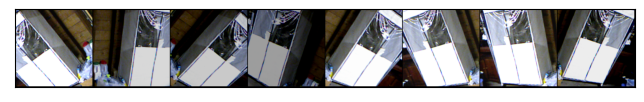

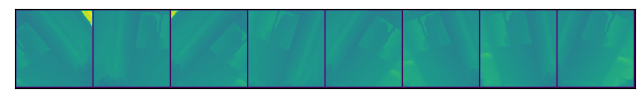

In [37]:
show_batch(train_loader,8)


In [38]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [39]:
i = 0
for param in model.parameters():
    i= i + 1
    if(i == 300):
        break
    param.requires_grad = False
print(i)    

161


In [41]:

for param in model.parameters():
    param.requires_grad =True

In [42]:


class SSIM(torch.nn.Module):
    def __init__(self):
        super(SSIM, self).__init__()
        

    def forward(self, x, y):
        Mx = torch.mean(x)
        My = torch.mean(y)
        xy = x * y
        #Vx = torch.mean((x - Mx) ** 2)
        Vx = torch.mean((x) ** 2) - Mx**2
        #Vy = torch.mean((y - My) ** 2)
        Vy = torch.mean((y) ** 2) - My**2
        Vxy = torch.mean(xy) - Mx * My
        Vcxy = torch.mean((x - Mx)*(y - My))
        c1 = (0.01)**2 
        c2 = (0.03)**2
        
        l = (2 * Mx * My + c1)/(Mx**2 + My**2 + c1)
        c = (2 * torch.sqrt(Vx * Vy) + c2)/(Vx + Vy + c2)
        s = (Vxy + c2/2) / (torch.sqrt(Vx * Vy) + c2/2)

        #ssim = (2*Mx*My + c1) * (2*Vxy + c2)/(Mx**2 + My**2 + c1)*(Vx**2 + Vy**2 + c2) 
        ssim = l * c * s
        lssim = torch.clamp((1 - ssim)*0.5,0,1)
        return ssim

In [43]:
class Loss_Function(nn.Module):
    def __init__(self):
        super().__init__()
        self.L1 = nn.L1Loss()
        self.ssim = SSIM()
    def forward(self,yhat,y):
        loss = self.L1(yhat, y)
        loss1 = torch.abs(self.ssim(yhat, y)) 
        return loss * 0.1 + loss1

In [44]:
#model =UNET().to(DEVICE)
#load from checkpoint
#model.load_state_dict(torch.load("D:\\DLStudy\\nyuDepth\\model\\2023-09-03_14-57_3_checkpoint.pth"))

model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()
    

In [45]:
#loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()
loss_fn = Loss_Function()

In [46]:
def Average(lst):
    return sum(lst) / len(lst)

In [47]:
def train(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    history = 0
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device = DEVICE)
        targets = targets.to(device = DEVICE)
        
        #forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            #loss = loss_fn(predictions['out'], targets)
            loss = loss_fn(predictions, targets)
            history= history + loss.item()
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loop.set_postfix(loss = loss)
    history = history/len(loader)
    return history    

In [48]:
def save_result(epoch):
    i = 0
    for batch in train_loader:
        i = i+ 1
        if(i==100): 
            image, depth = batch
            r = model(image.cuda())
            f, axarr = plt.subplots(2,4)
            for ax in axarr.flatten():
                ax.set_xticks([])
                ax.set_yticks([])
            for i in range(4):
                axarr[0][i].imshow(depth[i].detach().permute(1,2,0))
                axarr[1][i].imshow(r[i][0].cpu().detach().numpy())
            PATH = os.path.join(os.getcwd(), "result", datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+"_" +str(epoch) + ".jpg")
            plt.savefig(PATH)
            break


In [ ]:
result = []
for epoch in range(NUM_EPOCHS):
    l = train(train_loader, model, optimizer, loss_fn, scaler)
    result.append(l)

    PATH = os.path.join(os.getcwd(), "model", "resnet50", datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+"_" + str(l) + "_" +str(epoch) + ".pth")
    torch.save(model.state_dict(), PATH)
    if(epoch % 3 == 0):save_result(epoch)

  0%|                                                                                         | 0/5948 [00:00<?, ?it/s]d:\python\python37\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([8, 1, 112, 112])) that is different to the input size (torch.Size([8, 64, 112, 112])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
 62%|█████████▉      | 3692/5948 [28:57<17:43,  2.12it/s, loss=tensor(0.0533, device='cuda:0', grad_fn=<AddBackward0>)]

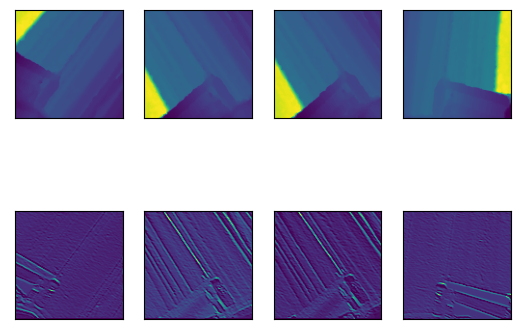

In [49]:
save_result(0)